In [1]:
import requests
import pandas as pd

# GitHub의 파일 URL
url = "https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz"

# 파일 다운로드
response = requests.get(url)
file_name = "un-general-debates-blueprint.csv.gz"

# 로컬에 파일 저장
with open(file_name, "wb") as file:
    file.write(response.content)

# 압축된 CSV 파일 읽기
df = pd.read_csv(file_name, compression='gzip')

# 데이터 확인
print(df.head())

   session  year country country_name             speaker position  \
0       25  1970     ALB      Albania             Mr. NAS      NaN   
1       25  1970     ARG    Argentina  Mr. DE PABLO PARDO      NaN   
2       25  1970     AUS    Australia         Mr. McMAHON      NaN   
3       25  1970     AUT      Austria  Mr. KIRCHSCHLAEGER      NaN   
4       25  1970     BEL      Belgium          Mr. HARMEL      NaN   

                                                text  
0  33: May I first convey to our President the co...  
1  177.\t : It is a fortunate coincidence that pr...  
2  100.\t  It is a pleasure for me to extend to y...  
3  155.\t  May I begin by expressing to Ambassado...  
4  176. No doubt each of us, before coming up to ...  


In [2]:
df['length'] = df['text'].str.len()

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [4]:
df[['country', 'speaker']].describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
speaker,7480,5428,Seyoum Mesfin,12


In [5]:
df.isnull().sum()

,0
session,0
year,0
country,0
country_name,0
speaker,27
position,3005
text,0
length,0


In [6]:
df['speaker'].fillna('unknown', inplace=True)

<ipython-input-6-55236d251c8f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speaker'].fillna('unknown', inplace=True)


In [7]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

,count
speaker,
George W. Bush,4
Mr. George W. Bush,2
Bush,1
George Bush,1
Mr. George W Bush,1


<Axes: >

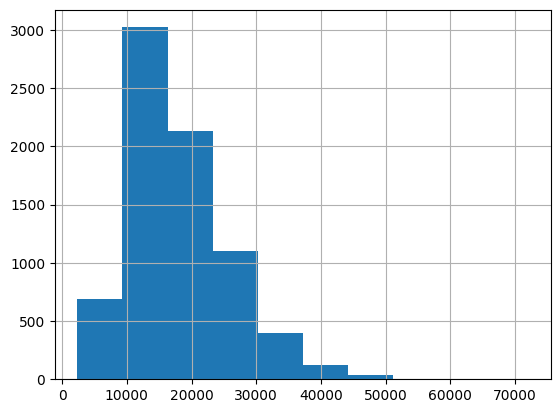

In [8]:
df['length'].hist()

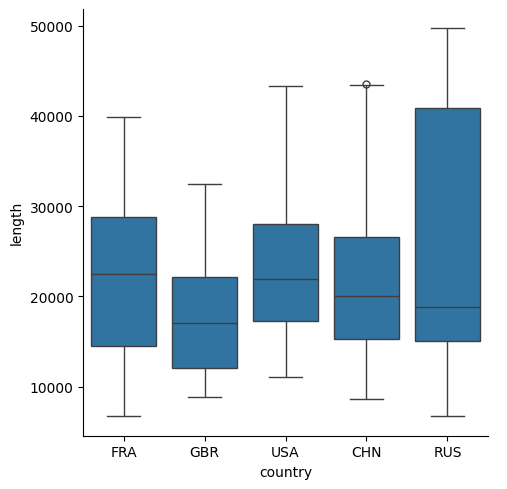

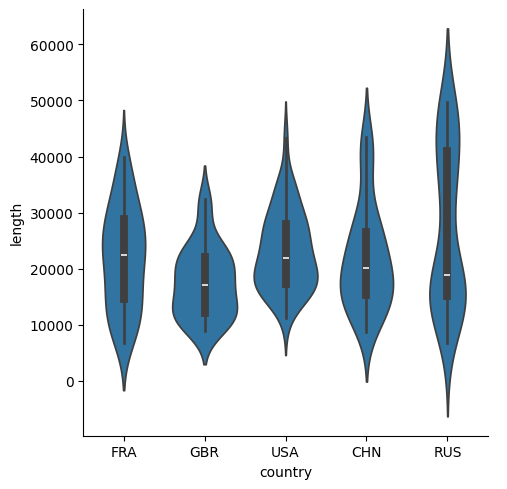

In [9]:
import seaborn as sns

where = df['country'].isin(['USA','FRA','GBR','CHN','RUS'])
sns.catplot(data=df[where], x='country',y='length', kind='box')
sns.catplot(data=df[where], x='country',y='length',kind='violin')

## 시간 경과에 따른 변화 시각화

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

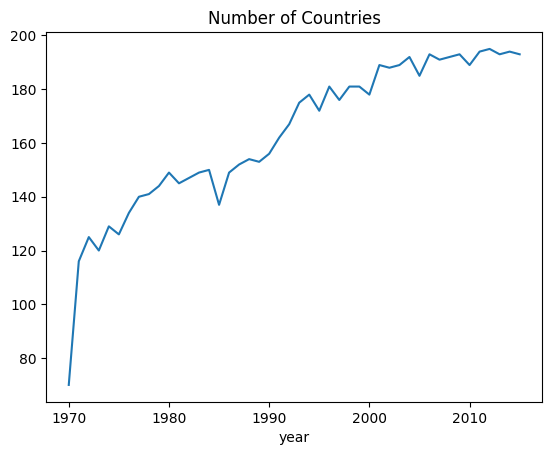

In [10]:
df.groupby('year').size().plot(title='Number of Countries')

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

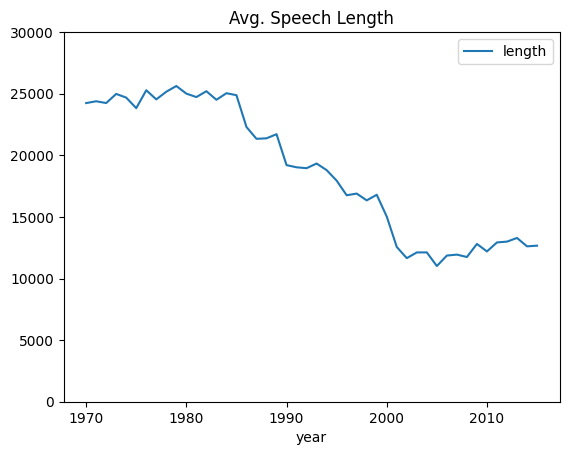

In [11]:
df.groupby('year').agg({'length':'mean'}).plot(title='Avg. Speech Length', ylim=(0, 30000))

## Tokenizer


In [12]:
import regex as re
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [13]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


## 불용어
: 텍스트에서 가장 자주 사용되는 단어는 한정사, 조동사, 대명사, 부사 같은 일반적인 단어, 불용어는 많은 정보를 전달하지 않지만 출현 빈도가 높기 때문에 중요한 내용을 놓치게 만든다.

In [53]:
import nltk

# Stopwords 리소스 다운로드
nltk.download('stopwords')

# Stopwords 사용
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)


{"mustn't", 'each', 't', 'needn', 'yourself', 'doesn', 'until', 'few', 'ours', 're', 'on', 'too', 'isn', 'y', 'herself', "wouldn't", 'through', 'during', 's', 'but', 'more', 'over', 'with', "shan't", 'that', 'me', 'further', 'they', 'and', 'after', 'his', 'out', 'those', "you're", 'than', 'be', 'we', 'shouldn', 'when', 'ma', "couldn't", "it's", 'all', 'here', 'you', 'hasn', "you'd", 'having', 'or', 'some', 'are', 'been', 'under', "doesn't", 'which', 'the', 'very', 'couldn', "wasn't", 'have', 'your', 'at', 'its', 'such', 'theirs', 'not', 've', 'our', 'were', 'these', 'between', 'then', 'where', 'hadn', 'before', 'won', "didn't", 'yours', 'is', "should've", 'himself', 'now', 'what', "weren't", 'while', 'against', 'i', 'him', 'below', "won't", 'up', 'only', 'again', 'any', 'why', 'ourselves', 'same', 'o', 'had', 'their', 'it', 'once', "shouldn't", 'above', 'into', 'just', 'both', 'themselves', 'am', 'how', 'her', 'should', 'll', 'haven', 'itself', 'will', 'he', 'as', "hadn't", 'mightn', "

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

# 코드 한줄로 파이프라인 형성

In [16]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [17]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [18]:
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation..."
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit..."
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839,"[pleasure, extend, mr, president, warmest, con..."
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,26616,"[may, begin, expressing, ambassador, hambro, b..."
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",25911,"[doubt, us, coming, rostrum, wonders, usefulne..."


In [19]:
df['num_tokens'] = df['tokens'].map(len)

In [20]:
df.head()

,session,year,country,country_name,speaker,position,text,length,tokens,num_tokens
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation...",4092
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit...",2341
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,31839,"[pleasure, extend, mr, president, warmest, con...",2575
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,26616,"[may, begin, expressing, ambassador, hambro, b...",2166
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...",25911,"[doubt, us, coming, rostrum, wonders, usefulne...",2064


## 파이썬 Counter 클래스를 이용한 단어 개수

In [21]:
from collections import Counter

tokens = tokenize('She likes my cats and my cats like my sofa.')

counter =Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [22]:
more_tokens = tokenize('She likes dogs and cats')
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [23]:
counter = Counter()

df['tokens'].map(counter.update)

,tokens
0,None
1,None
2,None
3,None
4,None
...,...
7502,None
7503,None
7504,None
7505,None


# most_common
  - counter의 most_common 함수를 사용해 텍스트에서 가장 빈번하게 나오는 단어를 검색

In [24]:
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


## 상위 5개 토큰

In [25]:
from collections import Counter
import pandas as pd
from tqdm import tqdm

# tqdm 초기화
tqdm.pandas()

# 함수 정의
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [26]:
freq_df = count_words(df)
freq_df.head(5)

100%|██████████| 7507/7507 [00:02<00:00, 3129.78it/s]


,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [27]:
count_words(df, column='text', preprocess=lambda text: re.findall(r"\w{10,}",text))

100%|██████████| 7507/7507 [00:15<00:00, 492.10it/s]


,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
enfranchising,2
interrelate,2
compositions,2


## 빈도 다이어그램

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

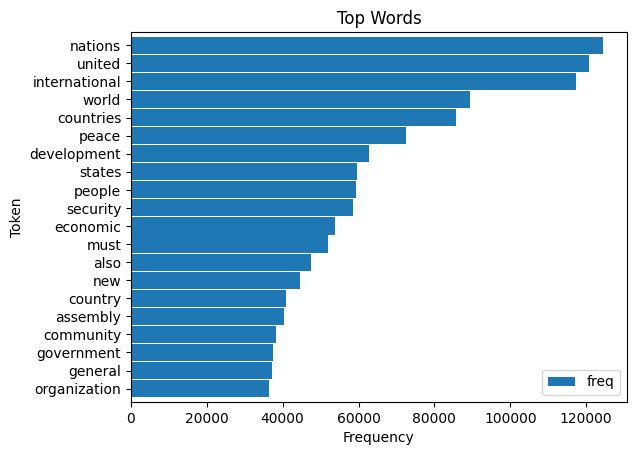

In [28]:
ax = freq_df.head(20).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency',ylabel='Token',title='Top Words')

## 워드클라우드 생성

(-0.5, 399.5, 199.5, -0.5)

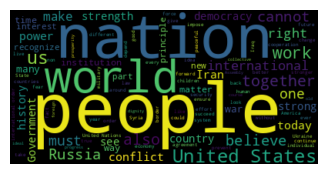

In [29]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]

plt.figure(figsize=(4, 2)) ###
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [30]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

## 불용어 처리 되지않은것과 불용어처리 된 워드카운트

100%|██████████| 193/193 [00:00<00:00, 4359.37it/s]


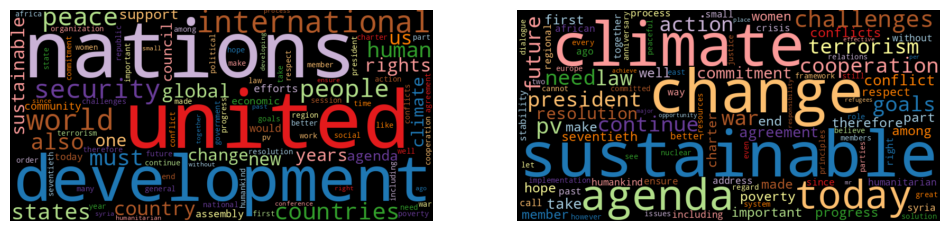

In [31]:
freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

In [32]:
import numpy as np
import pandas as pd
from collections import Counter

def compute_idf(df, column='tokens', preprocess=None, min_df=2):
    """
    Compute the Inverse Document Frequency (IDF) of tokens in a DataFrame column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column (str): Column name containing the tokens.
    - preprocess (callable): A function to preprocess the tokens (optional).
    - min_df (int): Minimum document frequency for tokens to be included.

    Returns:
    - pd.DataFrame: A DataFrame with tokens and their IDF values.
    """
    def update(doc):
        # Preprocess tokens if preprocess is provided, otherwise use raw tokens
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))  # Use `set` to count unique tokens per document

    # Initialize Counter to store document frequencies
    counter = Counter()

    # Apply update function to each document
    df[column].map(update)

    # Create a DataFrame from the Counter and compute IDF
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')  # Filter by minimum document frequency
    idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1  # Compute IDF with smoothing
    idf_df.index.name = 'token'

    return idf_df.sort_values('idf', ascending=False)


In [33]:
idf_df = compute_idf(df)

<ipython-input-32-745b7038c7f0>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1  # Compute IDF with smoothing


In [34]:
idf_df

,df,idf
token,,
shamin,2,8.330444
deign,2,8.330444
ow,2,8.330444
yu,2,8.330444
brainwash,2,8.330444
...,...,...
also,7412,0.112736
world,7460,0.106281
international,7466,0.105477


In [35]:
freq_df['tfidf'] = freq_df['freq']*idf_df['idf']

In [36]:
freq_1970 = count_words(df[df['year']==1970])
freq_2015 = count_words(df[df['year']==2015])

100%|██████████| 193/193 [00:00<00:00, 8600.55it/s]


In [37]:
freq_1970['tfidf'] = freq_1970['freq']*idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq']*idf_df['idf']

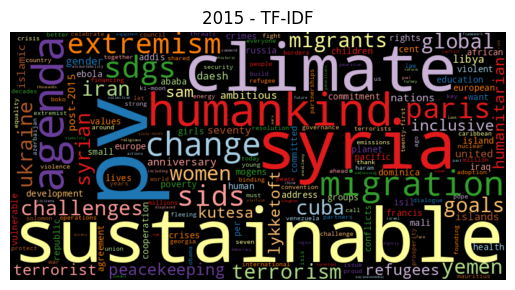

In [38]:
wordcloud(freq_1970['freq'], title='1970 - TF',stopwords=['twenty-fifth','twenty-five'])
wordcloud(freq_2015['freq'], title='2015 - TF',stopwords=['seventieth'])
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF',stopwords=['twenty-fifth','twenty-five','twenty','fifth'])
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF',stopwords=['seventieth'])


## 컨텍스트 내 키워드 검색
  - 키워드를 중심으로 왼쪽 및 오른쪽에 있는 일정한 개수의 단어를 목록화 한다.


In [43]:
import re
from typing import List
import random

def kwic(doc_series, keyword, window=35, print_samples=5):
    """
    Extract Key Word In Context (KWIC) from a series of documents.

    Parameters:
    - doc_series (pd.Series): Series of text documents.
    - keyword (str): Keyword to search for.
    - window (int): Number of characters before and after the keyword to include in context.
    - print_samples (int): Number of random samples to print (set to None or 0 to skip printing).

    Returns:
    - List[tuple]: List of tuples (left_context, keyword, right_context).
    """
    def extract_kwic(text, keyword, window):
        matches = []
        pattern = re.compile(rf'(.{{0,{window}}})\b({re.escape(keyword)})\b(.{{0,{window}}})', re.IGNORECASE)
        for match in pattern.finditer(text):
            matches.append((match.group(1).strip(), match.group(2), match.group(3).strip()))
        return matches

    kwic_list = []
    for text in doc_series:
        kwic_list.extend(extract_kwic(text, keyword, window))

    # Print random samples if required
    if print_samples and len(kwic_list) > 0:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        for sample in random.sample(kwic_list, k):
            print(f"{sample[0]} {sample[1]} {sample[2]}")

    return kwic_list


In [44]:
kwic(df[df['year'] == 2015]['text'],'sdgs',print_samples=5)

5 random samples out of 73 contexts for 'sdgs':
ersal support. That is because the SDGs mirror the hopes and aspirations o
also hinder the realization of the SDGs . We therefore call for the early l
population in accordance with the SDGs .
lementation and achievement of the SDGs .
the Sustainable Development Goals ( SDGs ), I quoted that portion of the Bib


[('the Sustainable Development Goals (',
  'SDGs',
  ') will be an effective tool in glob'),
 ('of Sustainable Development Goals (',
  'SDGs',
  '). Given the ambition reflected in'),
 ('the', 'SDGs', ', we surely will need to scale up t'),
 ('ead by example in implementing the',
  'SDGs',
  'in Bangladesh. Attaching due impor'),
 ('the Sustainable Development Goals (',
  'SDGs',
  '). In other words, it is addressing'),
 ('the Sustainable Development Goals (',
  'SDGs',
  ') will require countries, both deve'),
 ('transformative agenda. Many of the',
  'SDGs',
  'will not be attainable if we do no'),
 ('national strategies to achieve the',
  'SDGs',
  '. The education sector, which has a'),
 ('a necessarily ambitious vision and',
  'SDGs',
  '. We have no doubt of the complexit'),
 ('Development Goals (', 'SDGs', '). Beyond the immediate present, th'),
 (', to ensure the realization of the',
  'SDGs',
  '. The Commonwealth of Dominica is t'),
 ('initiatives aimed at achieving the', 'S

## N-gram 분석
  - 단어는 주로 합성어와 연어라는 두가지 유형의 단어 시퀀스를 찾는다. 합성어는 특정한 의미를 지닌 두 개 이상의 단어가 조합된 말이다. 영어에서는 earthquake(지진)같은 닫힌 형태, self-confident(자신감)같은 하이픈 형태, climate change(기후 변화)같은 열린 형태(open form)의 합성어를 찾는다. 따라서 두개의 토큰을 하나의 의미로 간주해야 한다.
  바이그램(bigram): 두 단어의 조합
  트라이그램(trigram): 세 단어의 조합

In [46]:
def ngrams(tokens, n=2, sep=' '):
  return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [48]:
import regex as re

def tokenize(text):
    # 유니코드 속성을 활용하여 단어를 추출
    return re.findall(r'\p{L}+', text)

In [50]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [57]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [58]:
print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [59]:
df['bigrams'] = df['text'].apply(prepare, pipeline=[str.lower, tokenize]).apply(ngrams, n=2, stopwords=stopwords)

In [61]:
count_words(df, 'bigrams').head(5)

100%|██████████| 7507/7507 [00:02<00:00, 3468.85it/s]


,freq
token,
united nations,103565
international community,27791
general assembly,27112
security council,20985
human rights,20015


In [63]:
idf_df = compute_idf(df)
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams',min_df=10)])

<ipython-input-32-745b7038c7f0>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1  # Compute IDF with smoothing
<ipython-input-32-745b7038c7f0>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df) / idf_df['df']) + 0.1  # Compute IDF with smoothing


In [66]:
freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

100%|██████████| 193/193 [00:00<00:00, 7829.51it/s]


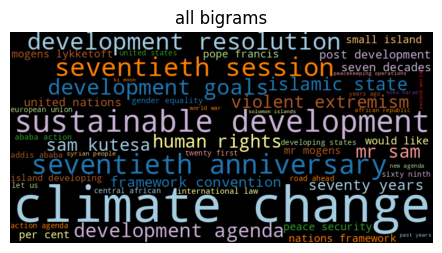

In [68]:
plt.figure(figsize=(12,6)) ###
plt.subplot(1,2,1) ###
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

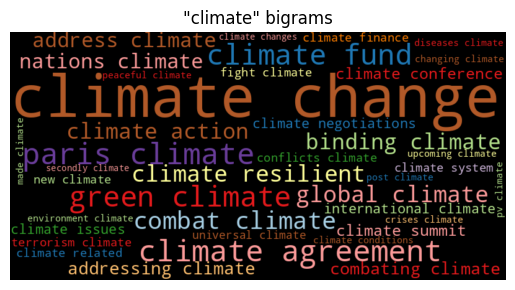

In [70]:
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'],title='"climate" bigrams',max_words=50)

# 시간 및 범주에 따른 빈도 비교

In [73]:
## 빈도 타임라인 생성
def count_keywords(tokens, keywords):
  tokens = [t for t in tokens if t in keywords]
  counter = Counter(tokens)
  return [counter.get(k, 0) for k in keywords]

In [72]:
keywords = ['nuclear','terrorism','climate','freedom']
tokens = ['nuclear','climate','climate','freedom','climate','freedom']

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [74]:
def count_keywords_by(df, by, keywords, column='tokens'):
  freq_matrix = df[column].apply(count_keywords, keywords=keywords)
  freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
  freq_df[by] = df[by]
  return freq_df.groupby(by=by).sum().sort_values(by)

In [75]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [76]:
freq_df

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


<Axes: xlabel='year'>

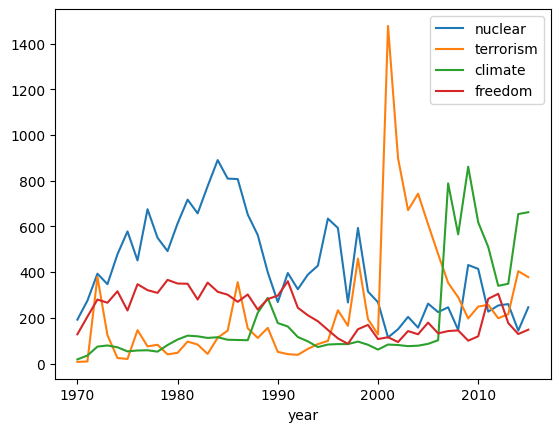

In [78]:
## 꺽은선 차트 시각화
freq_df.plot(kind='line')